In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import json
from efficientnet_pytorch import EfficientNet

from torchvision import transforms

# Custom imports
sys.path.insert(0, "../")
from utils import grid_plot


sys.path.insert(0, "../")
from utils import class_sampler, grid_plot
import schedulers
from schedulers import *
from constraints import *
from objectives import *
from distances import *
from methods import *
from projections import *
from models.pretrained import EfficientNetClassifier, ImagenetBigBiGAN

z_all = np.load(r"C:\Users\cerma\projects\generate-ae\experiments\input_images\bigbigan_z.npy")
z_all = torch.tensor(z_all)
labels_map = json.load(open('labels_map.txt'))

Loaded pretrained weights for efficientnet-b0


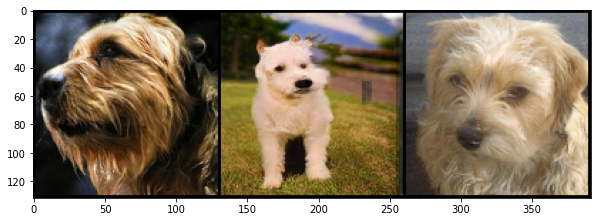

['otterhound, otter hound', 'West Highland white terrier', 'Norfolk terrier']

In [148]:
classifier = EfficientNetClassifier('cpu')
bgan = ImagenetBigBiGAN(1, 'cpu')

x = bgan(z_all)
grid_plot(x, nrows=3, figsize=(10, 100))

output = classifier(x)
classes = output.argmax(1)

[labels_map[str(i.item())] for i in classes]

### Untargeted attack

In [90]:
z0 = z_all[:1]
gp_generator = ImagenetBigBiGAN(3, 'cpu')
classifier = EfficientNetClassifier('cpu')
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)

rho = SchedulerStep(10e6, gamma=1, n=10)
xi = SchedulerExponential(initial=1, gamma=0.01)
distance = L2(Decoded(gp_generator))

Loaded pretrained weights for efficientnet-b0


In [91]:
%%time
v_per = penalty_method(v0, distance, gp_combined, xi, rho, grad_norm='l2', iters=50)

Wall time: 1min 3s


['Norfolk terrier']


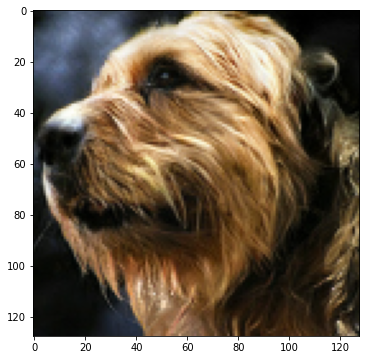

In [92]:
x = gp_generator.decode(v_per)
classes = classifier(x).argmax(1)
print([labels_map[str(i.item())] for i in classes])
grid_plot(x)

['otterhound, otter hound']


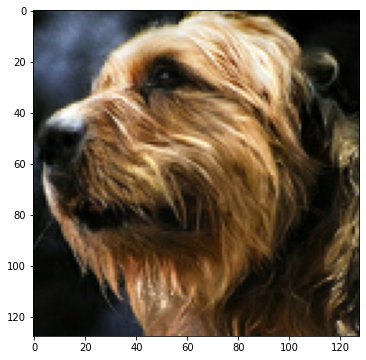

In [93]:
x0 = gp_generator.decode(v0)
classes = classifier(x0).argmax(1)
print([labels_map[str(i.item())] for i in classes])
grid_plot(x0)

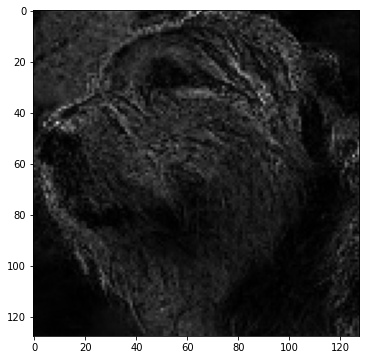

In [94]:
dif = (x0 - x).abs().sum(1)
grid_plot(dif)

## Targeted

In [95]:
from methods import calculate_batch
@calculate_batch(variables=2)
def penalty_method_targeted(x0, target_y, distance, model, xi, rho, grad_norm='l2', iters=100, max_unchanged=10):
    '''
    Penalty method with distance as objective and misclassification constraint. 
    Penalty function: max(g(x), 0)^2
    '''
    constraint = ConstraintMisclassify(x0, model)
    constraint = ConstraintClassifyTarget(target_y, model)
    result = torch.full_like(x0, float('nan'))

    x = x0.clone()
    unchanged = 0
    for t in range(iters):
        # Optimization step
        l = lambda x: distance(x0, x) + rho(t)*F.relu(constraint(x))**2
        grad = calculate_gradients(l, x, norm=grad_norm)
        x = x - xi(t)*grad

        # Termination condition
        if torch.sign(constraint(x)) > 0:
            unchanged += 1
        else:
            unchanged = 0
            result = x
        if unchanged > max_unchanged:
            break
    return result.detach()

class ConstraintClassifyTarget(Constraint):

    def __init__(self, y, model, softmax=True):
        super().__init__()
        self.margin = Margin()
        self.y = y
        self.model = model
        self.softmax = softmax

    def forward(self, x, subset=None):
        if subset is not None:
            y = self.y[subset]
        else:
            y = self.y

        if x.shape[0] != y.shape[0]:
            raise ValueError('x and subset of x0 have different batch size.')

        prediction = self.model(x)
        # TODO there should be a check that prediction has at most two dimensions
        if self.softmax:
            prediction = F.softmax(prediction, 1)
        return self.margin(prediction, y)


In [104]:
z0 = z_all[:1]
gp_generator = ImagenetBigBiGAN(2, 'cpu')
classifier = EfficientNetClassifier('cpu')
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)

rho = SchedulerStep(10e10, gamma=1, n=10)
xi = SchedulerExponential(initial=1, gamma=0.01)
distance = L2(Decoded(gp_generator))

target_labels = torch.tensor([937], dtype=torch.int64, device=v0.device)

Loaded pretrained weights for efficientnet-b0


In [105]:
%%time
v_per = penalty_method_targeted(v0, target_labels, distance, gp_combined, xi, rho, grad_norm='l2',
                                iters=1000, max_unchanged=100)

Wall time: 11min 56s


['broccoli']


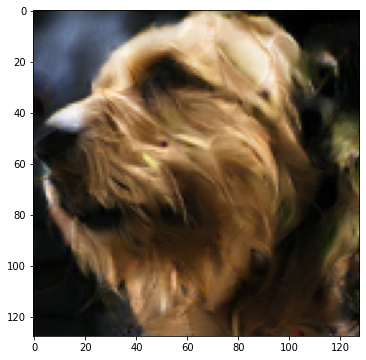

In [146]:
x = gp_generator.decode(v_per)
classes = classifier(x).argmax(1)

print([labels_map[str(i.item())] for i in classes])
grid_plot(x)

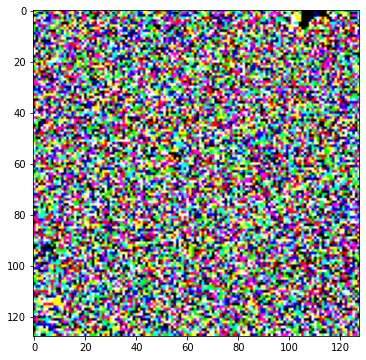

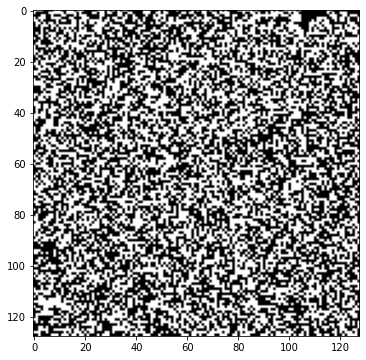

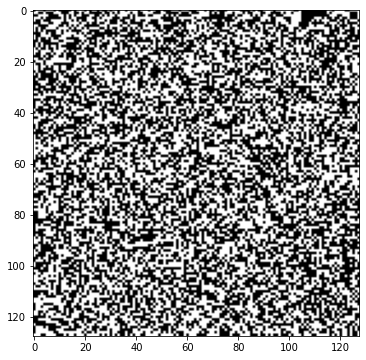

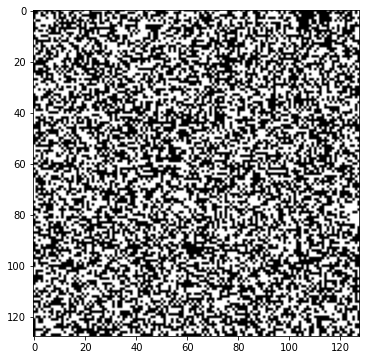

In [122]:
lsb = least_significant_bits(x)

grid_plot(lsb)
lsb.mean(dim=(2, 3))

x1 = lsb[:, 0, :, :].unsqueeze(1)
x2 = lsb[:, 1, :, :].unsqueeze(1)
x3 = lsb[:, 2, :, :].unsqueeze(1)

grid_plot(x1)
grid_plot(x2)
grid_plot(x3)

['otterhound, otter hound']


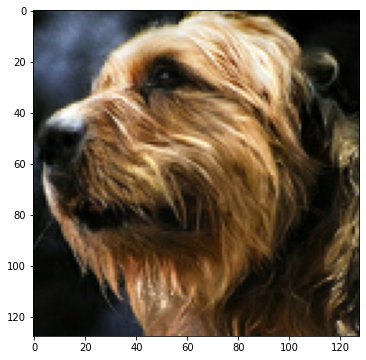

In [123]:
x0 = gp_generator.decode(v0)
classes = classifier(x0).argmax(1)
print([labels_map[str(i.item())] for i in classes])
grid_plot(x0)

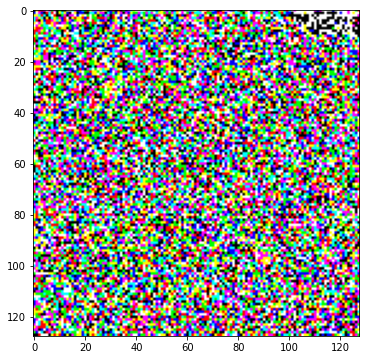

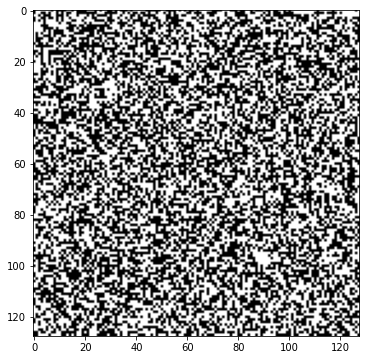

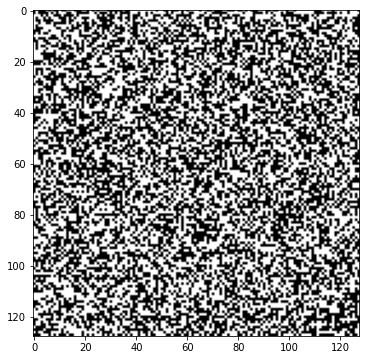

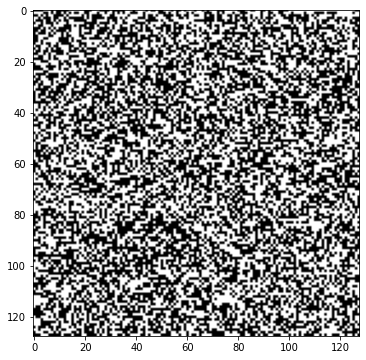

In [124]:
lsb = least_significant_bits(x0)

grid_plot(lsb)
lsb.mean(dim=(2, 3))

x1 = lsb[:, 0, :, :].unsqueeze(1)
x2 = lsb[:, 1, :, :].unsqueeze(1)
x3 = lsb[:, 2, :, :].unsqueeze(1)

grid_plot(x1)
grid_plot(x2)
grid_plot(x3)

In [55]:
def least_significant_bits(sample):
    sample_int = (sample*255).type(torch.uint8)
    lsb = torch.remainder(sample_int, 2).type(torch.float)
    return lsb


### Difference

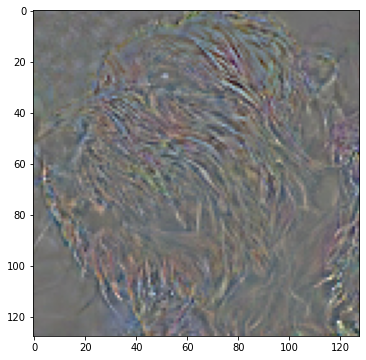

In [145]:
dif = (x0 - x)
grid_plot(dif)

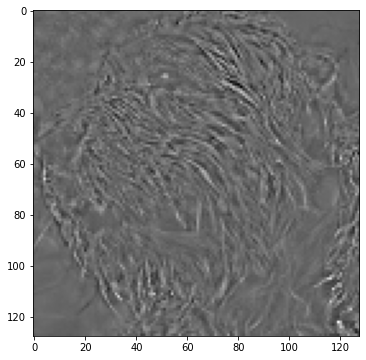

In [132]:
dif = (x0 - x).sum(1)
grid_plot(dif)

### Absolute difference

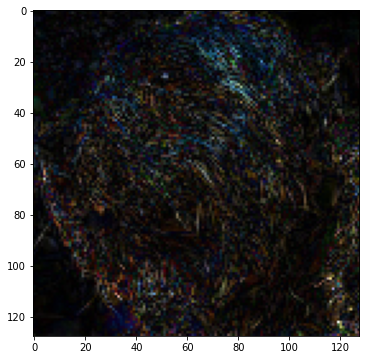

In [127]:
dif = (x0 - x).abs()
grid_plot(dif)

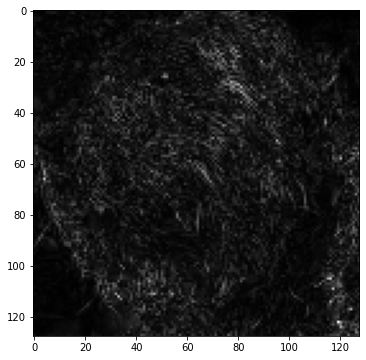

In [133]:
dif = (x0 - x).abs().sum(1)
grid_plot(dif)